In [42]:
import re
from datetime import date
import datetime
import pickle
import seaborn as sns

import requests
import pandas as pd
from datetime import datetime
import time, math
import matplotlib.pyplot as plt
#import toolboxes
from reddit_toolbox import piecewise_lin_fit, search_mentions, search_drug_pattern
# Getting data:
with open('objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
     data_combined_with_delta = pickle.load(f)
with open('objs.pkl.bkp', 'rb') as f:  # Python 3: open(..., 'rb')
     data_combined_with_delta_bkp = pickle.load(f)


In [122]:
# compare two data sets
x = set(data_combined_with_delta.loc['1P_LSD',:]['name'].reset_index()['id'])
y = set(data_combined_with_delta_bkp.loc['1P_LSD',:]['name'].reset_index()['id'])
a = y - x
len(list(a))

56

In [124]:
# x = data_combined_with_delta.loc['1P_LSD',:]['name'].reset_index()
# x.set_index( 'id', inplace=True)
# y = data_combined_with_delta_bkp.loc['1P_LSD',:]['name'].reset_index()
# y.set_index( 'id', inplace=True)



In [21]:
def function_find_pattern(string_to_search, dict_of_kwrds):
    r = re.compile('\\b'+string_to_search.strip()+'\\b', flags=re.I)
    newlist = list(filter(lambda elem: r.search(elem[1]), dict_of_kwrds.items()))
    if len(newlist) == 0:
        return string_to_search
    else:
        return dict_of_kwrds[newlist[0][0]]


In [22]:
drug_kwrds = {'4-FA' : '4-FA|4FMP', 
              '4-MMC': '4-MMC|mephedrone | mefedron',
              '6-ABP': '6-APB| Benzofury| Benzo Fury',
              'A-PHP'  : 'alpha-PHP|α-PHP|a-php',
              'Phenibut': 'Phenibut|fenibut'

             }

assert function_find_pattern('Mefedron', drug_kwrds)=='4-MMC|mephedrone | mefedron', 'didn''t find correct search words'
assert function_find_pattern('mefe', drug_kwrds)=='mefe', 'didn''t find correct search words'
assert function_find_pattern('ZZZZ', drug_kwrds)=='ZZZZ', 'didn''t find correct search words'


In [23]:
data_combined_with_delta['num_comments'].fillna(0, inplace=True)
data_combined_with_delta['upvote_ratio'].fillna(0, inplace=True)
data_combined_with_delta['ups'].fillna(0, inplace=True)
data_combined_with_delta['downs'].fillna(0, inplace=True)
data_combined_with_delta['score'].fillna(0, inplace=True)


In [24]:
def plots(drug, data_field, data_frame):
    
    data_frame[data_field+'agg'] = \
    data_frame[data_field]*data_frame['contains'].astype('float')
    
    X = data_frame[['year_month',data_field+'agg']].groupby('year_month').sum()

    output  = piecewise_lin_fit(X, data_field+'agg', 6)

    
    plt.figure(figsize=(15,5))
    plt.plot(X.index, X[data_field+'agg'], label='sum')
    plt.plot(output['year_month'], output['average'], label='average')
    plt.plot(output['year_month'], output['pwlf'], label='pwlf')
    plt.xticks(rotation=45)
    plt.xlim(date(2015, 12, 1), date(2023, 2, 1))
    plt.legend()
    plt.title(f'{drug} {data_field}')

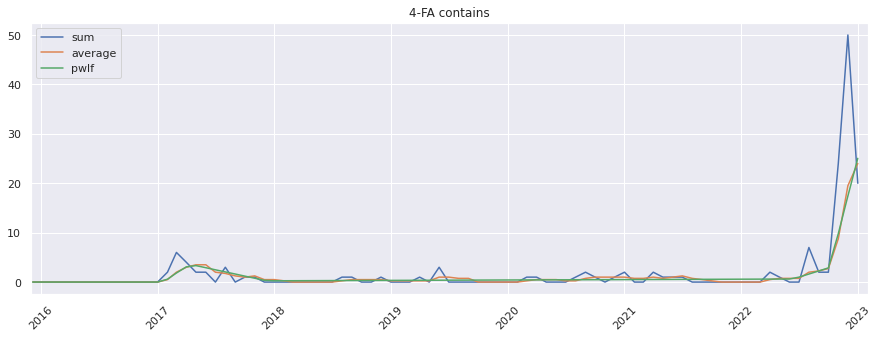

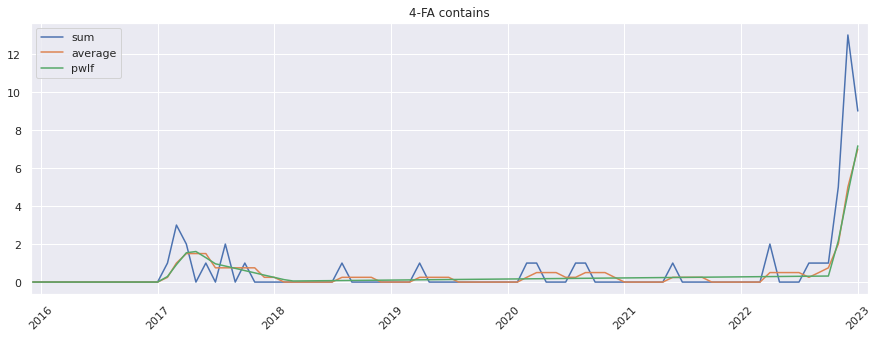

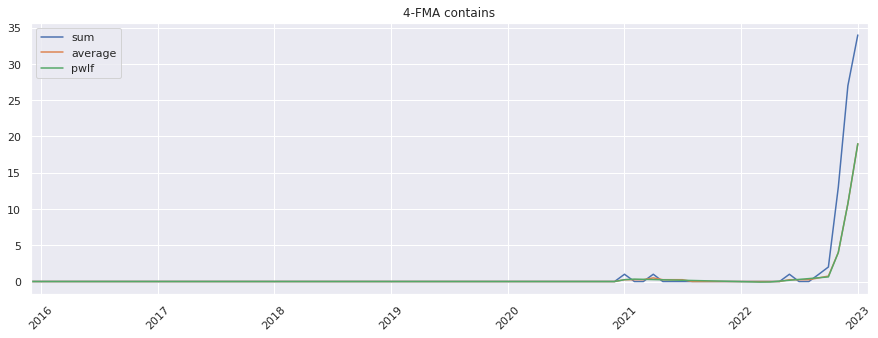

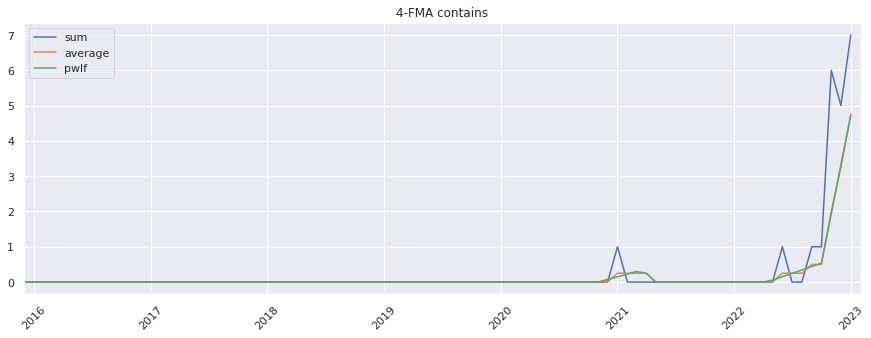

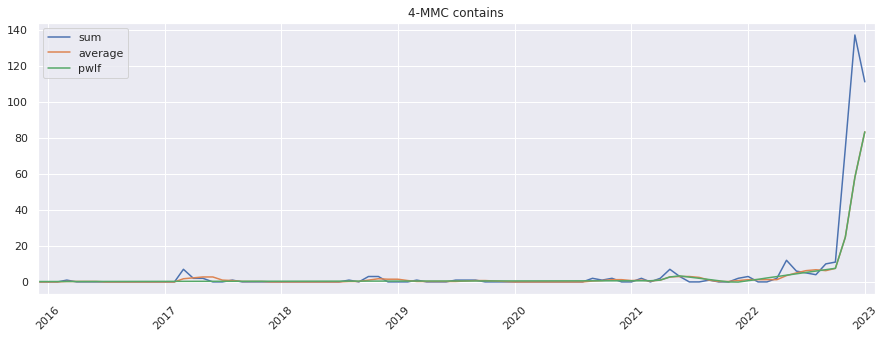

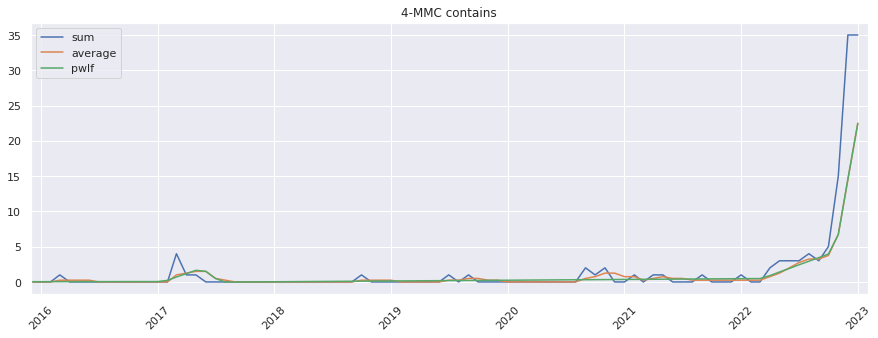

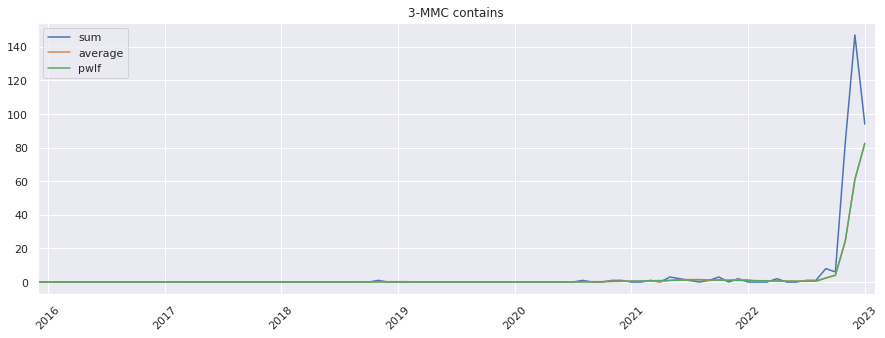

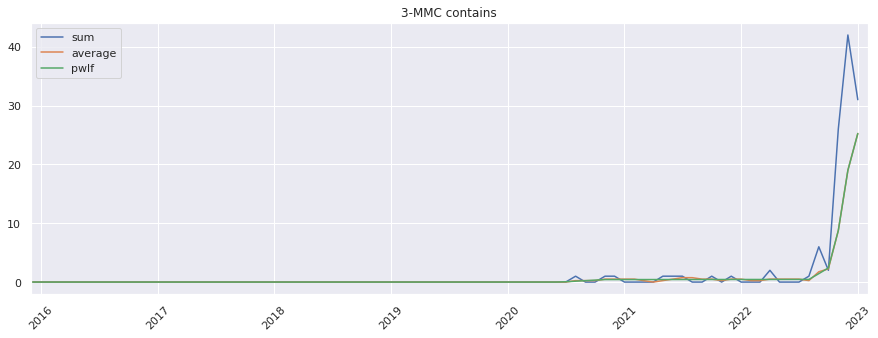

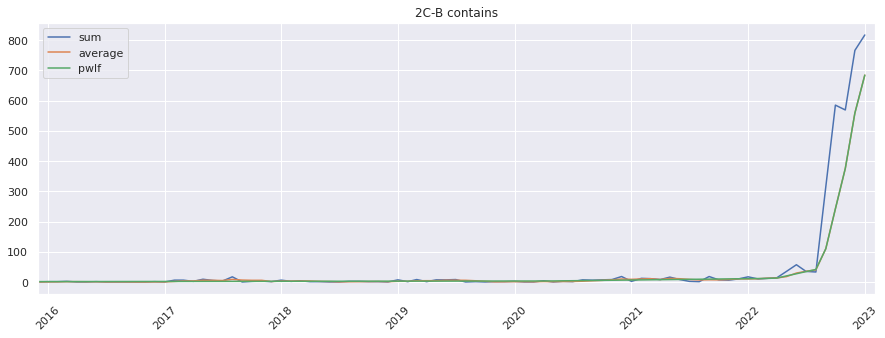

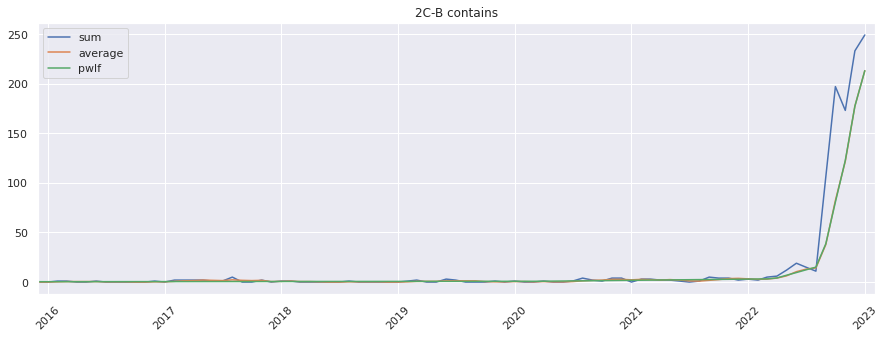

In [25]:
search_drugs = ['4-FA', '4-FMA', '4-MMC', '3-MMC', '2C-B']

drug_mentions = pd.DataFrame()
sns.set()

for i, drug in enumerate(search_drugs):

    search_mentions(data_combined_with_delta, drug_name=function_find_pattern(drug, drug_kwrds) )
    
    data_no_comments = data_combined_with_delta[data_combined_with_delta['kind']=='t3'].reset_index()
    
    data_field = 'contains'
    plots(drug, data_field, data_combined_with_delta)    
   
    plots(drug, data_field, data_no_comments)

    


In [125]:
trimbos = pd.read_csv('../../../corpus/trimbos/trimbos_data.csv')


In [126]:
trimbos

,year,4-fa,4-fma,4-mmc,3-mmc,2-cb
0,2012,41,0,2,1,82
1,2013,80,3,10,4,102
2,2014,309,4,18,2,153
3,2015,698,0,29,5,268
4,2016,1065,3,81,15,308
5,2017,684,22,62,25,425
6,2018,457,30,44,39,531
7,2019,363,42,68,51,1151
8,2020,62,8,72,75,788
9,2021,43,19,79,110,873


In [163]:
data_combined_with_delta['year'] = pd.to_datetime(data_combined_with_delta['created_utc']).dt.strftime('%Y')
data_combined_with_delta['year'] = data_combined_with_delta['year'].astype('int')

In [174]:
data

,trimbos,year,contains_4-FA,average,pwlf
0,41,2012,0.0,0.00,6.788922e-12
1,80,2013,0.0,0.00,9.572758e-12
2,309,2014,0.0,0.00,1.235659e-11
3,698,2015,0.0,0.00,1.514043e-11
4,1065,2016,0.0,0.00,1.792427e-11
5,684,2017,95.0,23.75,2.372500e+01
6,457,2018,23.0,29.50,2.845000e+01
7,363,2019,6.0,31.00,3.317500e+01
8,62,2020,32.0,39.00,3.790000e+01
9,43,2021,24.0,21.25,2.125000e+01


In [177]:
# def get_trimbos_nl_correlation(trimbos_data, reddit_data, metric='views'):
correlation_df = pd.DataFrame    
# metric = 'num_comments'
for i, drug in enumerate(search_drugs):
#     correlation_df['drug'] = drug
    search_mentions(data_combined_with_delta, drug_name=function_find_pattern(drug, drug_kwrds) )
    
    data_no_comments = data_combined_with_delta[data_combined_with_delta['kind']=='t3'].reset_index()
    
    for metrics in ['contains', 'num_comments']:
     
        field_name = metrics+'_'+drug

        data_no_comments[field_name] = data_no_comments[metric]*data_no_comments['contains'].astype('float')

        X = data_no_comments[['year', field_name]].groupby('year').sum()

        output  = piecewise_lin_fit(X, field_name, 6)
        metric_data = X
        moving_avg = output[['year','average']]
        piecewise = output[['year','pwlf']]

        data = pd.DataFrame()
        data['trimbos'] = trimbos[drug_name]
        data['year'] = trimbos['year']
        data = data.merge(metric_data, left_on='year', right_on='year')
        data = data.merge(moving_avg, left_on='year', right_on='year')    
        data = data.merge(piecewise, left_on='year', right_on='year')    
        
#         correlation_df[metrics] = data['trimbos'].corr(data[field_name])
#         correlation_df[metrics+'avg'] = data['trimbos'].corr(data['average'])
#         correlation_df[metrics+'pwlf'] = data['trimbos'].corr(data['pwlf'])

        
        print(field_name)
        print('actual: ', data['trimbos'].corr(data[field_name]))
        print('rolling: ', data['trimbos'].corr(data['average']))
        print('piecewise: ', data['trimbos'].corr(data['pwlf']))

contains_4-FA
actual:  0.13136520676854846
rolling:  -0.21283712789865364
piecewise:  -0.20866622280878788
num_comments_4-FA
actual:  0.13136520676854846
rolling:  -0.21283712789865364
piecewise:  -0.20866622281238628
contains_4-FMA
actual:  -0.3398831187443352
rolling:  -0.3398831187443352
piecewise:  -0.3398831187443604
num_comments_4-FMA
actual:  -0.3398831187443352
rolling:  -0.3398831187443352
piecewise:  -0.3398831187443145
contains_4-MMC
actual:  -0.2967979892247646
rolling:  -0.39455135447922274
piecewise:  -0.39464663293686125
num_comments_4-MMC
actual:  -0.2967979892247646
rolling:  -0.39455135447922274
piecewise:  -0.39464663208977613
contains_3-MMC
actual:  -0.4387427661322964
rolling:  -0.418615092551113
piecewise:  -0.4186150925510554
num_comments_3-MMC
actual:  -0.4387427661322964
rolling:  -0.418615092551113
piecewise:  -0.4186150925510195
contains_2C-B
actual:  -0.3749491102290489
rolling:  -0.41956455822707495
piecewise:  -0.4225622190456427
num_comments_2C-B
actual: 